In [1]:
import numpy as np
import pandas as pd
import skimage
import skimage.io
import os
import os.path as osp
import re
import tables
import sklearn as skl
import sklearn.neighbors
import sklearn.cluster
import scipy
import scipy.spatial.distance as sp
import scipy.stats as st
import matplotlib.pyplot as plt
import tqdm
import bokeh
import bokeh.io
import bokeh.plotting
import gudhi
import pyvista as pv

bokeh.io.output_notebook()

Loading BokehJS ...

In [2]:
base_dir = '~/CaiLab/'

# Developing genome-aware allele separation

In [4]:
data_1mb_1 = pd.read_csv(osp.join(base_dir, 'dna-if-analysis/data/DNAseqFISH+1Mbloci-E14-replicate1.csv'))
data_1mb_2 = pd.read_csv(osp.join(base_dir, 'dna-if-analysis/data/DNAseqFISH+1Mbloci-E14-replicate2.csv'))

In [5]:
data_1mb_1['rep'] = 1
data_1mb_2['rep'] = 2

data_1mb = pd.concat([data_1mb_1, data_1mb_2]).drop(columns='Unnamed: 0')

In [6]:
coords = pd.read_csv(osp.join(base_dir, 'dna-if-analysis/data/TableS0_Mbcoords.csv'),
                    usecols=['Region ID', 'Name', 'Chrom', 'Start', 'End', 'Chrom ID'])

coords.head()

Region ID     Name Chrom    Start      End  Chrom ID
0          1  chr1-#1  chr1  3100000  3125000         1
1          2  chr1-#2  chr1  5000000  5025000         1
2          3  Atp6v1h  chr1  5057518  5082518         1
3          4  chr1-#3  chr1  7000000  7025000         1
4          5  chr1-#4  chr1  8800000  8825000         1

In [7]:
data_1mb = pd.merge(data_1mb, coords, left_on='geneID', right_on='Name')

In [8]:
data_1mb['xnm'] = 103*data_1mb['x']
data_1mb['ynm'] = 103*data_1mb['y']
data_1mb['znm'] = 250*data_1mb['z']

In [9]:
data_1mb.to_csv(osp.join(base_dir, 'dna-if-analysis/data/DNA-1Mb-combined-data-coords.csv'), index=False)

In [10]:
del data_1mb_1, data_1mb_2

# Start here

In [3]:
data_1mb = pd.read_csv(osp.join(base_dir, 'dna-if-analysis/data/DNA-1Mb-combined-data-coords.csv'))

In [4]:
def fetch_cell_allele(data, rep, fov, cell, chrom=None, label=None):
    result = data.query(f'rep=={rep} & fov=={fov} & cellID=={cell}').copy()

    if chrom is not None:
        result = result.query(f'chromID=={chrom}')
    
    if label is not None:
        result = result.query(f'labelID=={label}')
        
    return result

In [5]:
cellcycle = pd.read_csv(osp.join(base_dir, 'dna-if-analysis/data/sc_meta_v2.csv'))

cellcycle.query('`Unnamed: 0`=="Cell_31"')

Unnamed: 0  fov  cellID  replicate  RNA_cluster_res.0.8  \
19    Cell_31    0      31          2                    3   

    IF_cluster_res.0.8  IF_cluster_res.1.5  dpt  dpt_cc  pcurve_cc  
19                   3                   2  246     142      187.0

In [6]:
test_cell = fetch_cell_allele(data_1mb, rep=1, fov=0, cell=31)

In [7]:
test_cell = test_cell.sort_values(by=['Chrom ID', 'Region ID'])

In [8]:
len(test_cell)

3488

# Naive first implementation

Compute pairwise distances within each chromosome. Step through by genomic coordinates and assign each allele to a cluster via pairwise distance and whether that cluster has that allele already. Possibly try to balance number in each allele?

In [9]:
test_chr = test_cell.query('`Chrom ID`==1').copy()

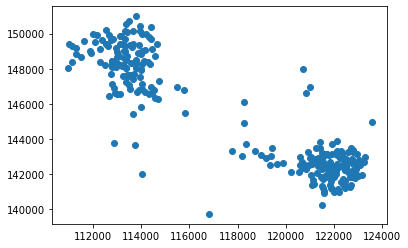

In [10]:
plt.scatter(test_chr['xnm'], test_chr['ynm'])
plt.show()

# Agglomerative clustering with connectivity matrix

* Connectivity matrix could exclude self-connections or only allow connections between neighboring loci

In [28]:
from allele_sep import (agg_cell, 
                        agg_alleles, 
                        inflate_selfdist, 
                        compute_n, 
                        nonself_discrete, 
                        make_neighbor_matrix,
                        summarize_clusters,
                        adhoc_alleles
                       )

In [12]:
%%time
inflated_results, inflated_testcell = agg_cell(
    test_cell, 
    points=inflate_selfdist, 
    affinity='precomputed',
    linkage='average',
    n_clusters=compute_n,
    save_results=True
)

CPU times: user 8.97 s, sys: 444 ms, total: 9.41 s
Wall time: 1.01 s


In [13]:
uninflated_results, uninflated_testcell = agg_cell(test_cell, 
         points=None, 
         affinity='euclidean',
         linkage='ward',
         n_clusters=compute_n,
         save_results=True
)

In [14]:
%%time
nonself_results, nonself_testcell = agg_cell(
    test_cell,
    affinity='euclidean',
    linkage='ward',
    connectivity=nonself_discrete,
    n_clusters=compute_n,
    save_results=True
)

CPU times: user 23.1 s, sys: 1.3 s, total: 24.4 s
Wall time: 2.6 s


In [15]:
%%time
scaling_results, scaling_testcell = agg_cell(
    test_cell,
    points=scaling_inflation,
    affinity='precomputed',
    linkage='average',
    n_clusters=compute_n,
    save_results=True
)

NameError: name 'scaling_inflation' is not defined

In [16]:
%%time
nbr_results, nbr_testcell = agg_cell(
    test_cell,
    #points=inflate_selfdist,
    affinity='euclidean',
    linkage='complete',
    connectivity=make_neighbor_matrix,
    #n_clusters=compute_n,
    distance_threshold=1000,
    save_results=True
)

CPU times: user 39.1 s, sys: 1.74 s, total: 40.9 s
Wall time: 8.72 s


In [17]:
p = bokeh.plotting.figure(x_axis_label='Percent nonunique loci (with scaling inflation)',
                         y_axis_label='Percent nonunique loci (with nonself connectivity)',
                         x_range=(-1, 1), y_range=(-1, 1))

p.circle(uninflated_testcell['Percent nonunique loci'], 
         nonself_testcell['Percent nonunique loci'],
        )

p.line([-1, 1], [-1, 1], color='gray')

bokeh.io.show(p)

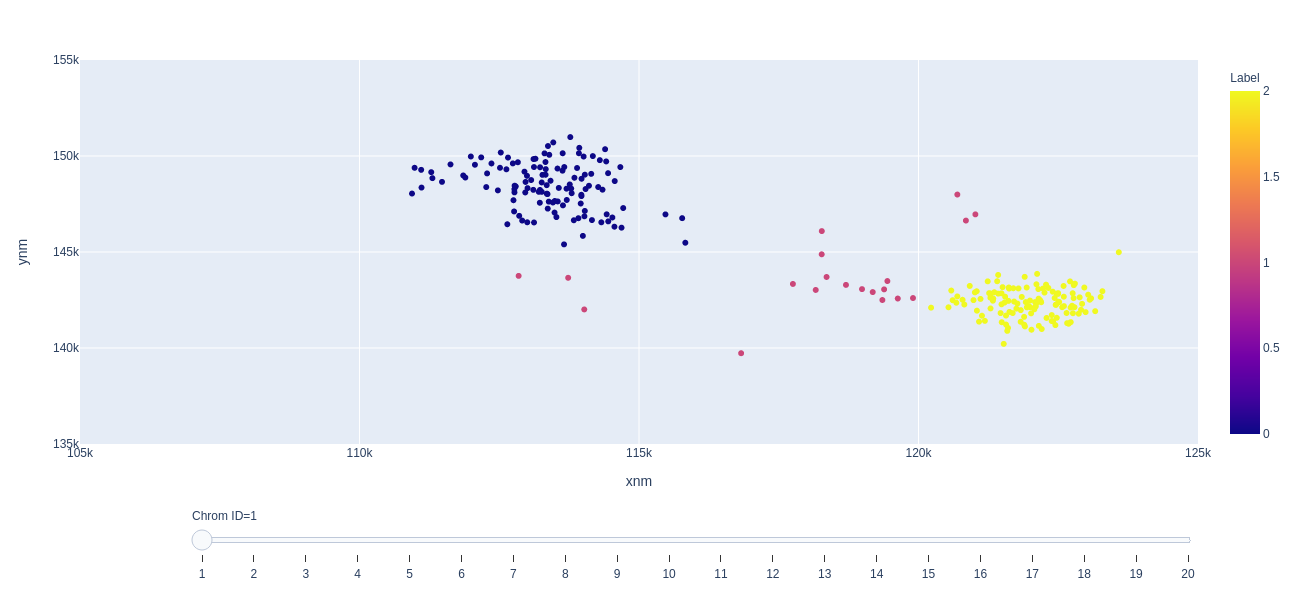

In [34]:
import plotly.express as px

fig = px.scatter(nonself_results, 
                x='xnm', y='ynm', 
                animation_frame='Chrom ID',
                #animation_group='Label',
                color='Label',
                range_x=[105e3, 125e3], range_y=[135e3, 155e3],
                width=600, height=600
                )

fig["layout"].pop("updatemenus") # optional, drop animation buttons
fig.show()


In [39]:
nonself_testcell

Label  Total loci  Percent nonunique loci    Path length  Path std dev  \
0       0         106                0.132075   99214.940374    491.154967   
1       1          17                0.176471   57185.290969   2857.062672   
2       2         109                0.165138   94730.242861    495.666391   
3       0          35                0.114286   46082.194805   1706.539714   
4       1          91                0.318681  143858.065287    703.699035   
5       2          79                0.189873   93122.412162    678.318512   
6       0          43                0.093023   66519.664217   1637.701330   
7       1          66                0.151515   66995.677083    560.194168   
8       2          75                0.133333   78999.660700    613.434052   
9       0          23                0.347826   54730.633806   2360.737683   
10      1          74                0.081081   58666.836761    404.086851   
11      2          78                0.076923   74715.639879    508.371312   
12      0          83                0.024096   68219.525948    856.213711   
13      1          52                0.134615   63273.583645    890.277289   
14      2          39                0.051282   28162.853436    365.353009   
15      0         105                0.085714   91990.790804    645.002185   
16      1          45                0.222222   70816.572823   1256.634093   
17      2          62                0.145161   54121.682296    616.923056   
18      0          77                0.207792   91736.439470    540.568387   
19      1          41                0.219512   48597.115959    527.701249   
20      2          44                0.113636   42210.787882    530.020120   
21      0          79                0.227848   97367.785156    701.956613   
22      1          28                0.357143   49488.374426   1599.746610   
23      2          47                0.148936   41564.749901    372.157790   
24      0          90                0.100000   82711.894151    673.605098   
25      1          76                0.118421   63169.741346    396.699517   
26      2           6                0.000000   12721.665684   1504.561824   
27      0          94                0.138298   77535.365277    401.376137   
28      1          76                0.131579   60808.106419    409.293813   
29      2           3                0.000000  151855.791000  73056.145500   
30      0          47                0.319149   71751.087292    962.260546   
31      1          42                0.119048   53103.351876   1293.584813   
32      2          61                0.098361   54309.056882    431.703966   
33      0          61                0.163934   63899.314676    643.043647   
34      1          65                0.046154   53368.904607    336.675148   
35      2           3                0.000000  147292.636000  69864.818000   
36      0          65                0.046154   53333.152498    563.944130   
37      1          79                0.139241   72804.097994    555.335485   
38      2           2                0.000000  142365.570000      0.000000   
39      0          63                0.063492   57597.520951    523.426934   
40      1          59                0.118644   64343.605890    566.652818   
41      2           2                0.000000  143804.789000      0.000000   
42      0          63                0.047619   59738.484472    990.218873   
43      1          36                0.166667   32484.101865    366.233421   
44      2          36                0.250000   35039.433450    442.483513   
45      0          64                0.187500   63227.360413    876.011250   
46      1          28                0.035714   23823.917623    489.303775   
47      2          37                0.027027   30093.348620    556.455057   
48      0          58                0.103448   52555.488705    427.542074   
49      1          56                0.035714   37128.131716    298.151989   
50      2           2     

In [40]:
nonself_results.head()

fov  cellID  channel   geneID         x         y       z  seeds  \
0    0      31        1  chr1-#1  1124.002  1424.883   9.622      3   
1    0      31        1  chr1-#1  1124.550  1412.458  14.801      3   
2    0      31        1  chr1-#2  1159.643  1393.065   9.602      5   
3    0      31        2  Atp6v1h  1121.103  1426.781   9.900      5   
4    0      31        2  Atp6v1h  1157.100  1387.501   8.959      5   

   intensity  rep  Region ID     Name Chrom    Start      End  Chrom ID  \
0       1124    1          1  chr1-#1  chr1  3100000  3125000         1   
1       1125    1          1  chr1-#1  chr1  3100000  3125000         1   
2       1160    1          2  chr1-#2  chr1  5000000  5025000         1   
3       1121    1          3  Atp6v1h  chr1  5057518  5082518         1   
4       1157    1          3  Atp6v1h  chr1  5057518  5082518         1   

          xnm         ynm      znm  Label  
0  115772.206  146762.949  2405.50      0  
1  115828.650  145483.174  3700.25      0  
2  119443.229  143485.695  2400.50      1  
3  115473.609  146958.443  2475.00      0  
4  119181.300  142912.603  2239.75      1

In [91]:
def color_nonuniques(df, label_col='Label'):
    
    choices = ['red', 'green', 'blue', 'orange', 'yellow', 'magenta', 'cyan', 'gray', 'purple', 'pink']
    result_temp = []
    
    for label, g1 in df.groupby(['Label']):
        
        c = 1
        
        for region, g2 in g1.groupby(['Region ID']):
        
            if len(g2) == 1:

                color = [-label]

            elif len(g2) > 1:
            
                color = np.repeat(c, len(g2))
                c += 1
                
            out = g2.copy()
            out['c_ind'] = color
            
            result_temp.append(out)
    
    
    result = pd.concat(result_temp)
    
    
    def c2color(c, cmax):
        
        from bokeh.palettes import viridis
        
        if c < 0:
            return ['#444', '#777', '#aaa', '#ddd'][-c]
        
        cmap = viridis(cmax)
        
        return cmap[c]

    result['Color'] = [ c2color(i, 20) for i in result['c_ind'].values ]
    
    return result

In [92]:
nonself_colored = color_nonuniques(nonself_results.query('`Chrom ID`==1'))

In [93]:
nonself_colored[['Region ID', 'Name', 'Label', 'Color']].head(10)

Region ID     Name  Label    Color
0           1  chr1-#1      0  #471466
1           1  chr1-#1      0  #471466
3           3  Atp6v1h      0  #440154
9           7  Arfgef1      0  #440154
11          8  chr1-#5      0  #472575
13          8  chr1-#5      0  #472575
14          9  chr1-#6      0  #453681
15          9  chr1-#6      0  #453681
16         10   Prdm14      0  #440154
19         11  chr1-#7      0  #440154

In [94]:
p = bokeh.plotting.figure()

p.circle(nonself_colored['xnm'], nonself_colored['ynm'], color=nonself_colored['Color'])

bokeh.io.show(p)

# Graph/network approach

In [17]:
import networkx as nx

# Nearest neighbors approach

Can maybe be utilize pairwise distances computed once.

In [675]:
spatial_neighbors = skl.neighbors.radius_neighbors_graph(
    test_chr[['xnm', 'ynm', 'znm']].values,
    3000, 
    mode='distance'
).toarray()

#spatial_neighbors /= spatial_neighbors.max()

In [676]:
test_chr['Region rank'] = test_chr['Region ID'].rank(method='dense')

In [677]:
genomic_dist = sp.squareform(sp.pdist(
    np.atleast_2d(test_chr['Region rank']).T
))

#genomic_dist /= genomic_dist.max()

In [712]:
genomic_thresh = np.bitwise_and(genomic_dist <= 1, genomic_dist > 0) # prohibit self connections
genome_modifier = np.where(genomic_thresh, genomic_thresh, genomic_dist)

In [713]:
composite = np.multiply(spatial_neighbors, genomic_thresh)

In [714]:
ng = nx.Graph(composite)

for i in ng.nodes:
    ng.nodes[i]['region'] = test_chr['Region ID'].values[i]

len(ng.edges)

266

In [715]:
nx.algorithms.number_connected_components(ng)

14

In [716]:
ccs = list(nx.algorithms.connected_components(ng))

cc_12 = ccs[0] | ccs[1]

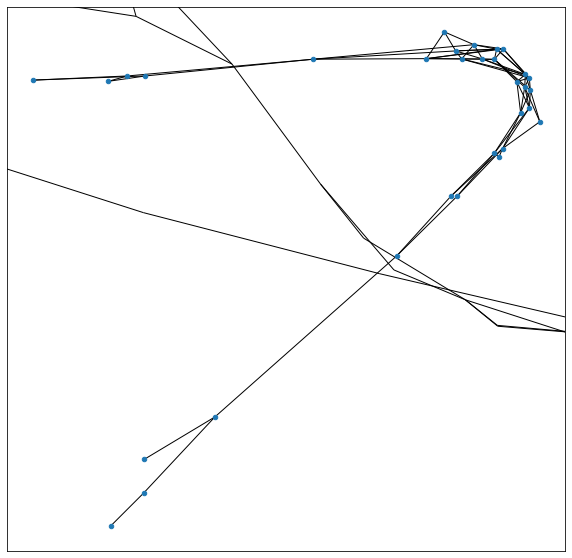

In [717]:
fig, ax = plt.subplots(figsize=(10,10))
nx.draw_networkx(ng, with_labels=False, nodelist=ccs[0], edge_cmap='viridis', font_weight='bold', node_size=20)
plt.show()

In [718]:
def equiv_region(u, v):
    return test_chr['Region rank'].values[u] == test_chr['Region rank'].values[v]

In [719]:
quot = nx.algorithms.quotient_graph(ng, equiv_region)

In [720]:
nx.algorithms.number_connected_components(quot)

7

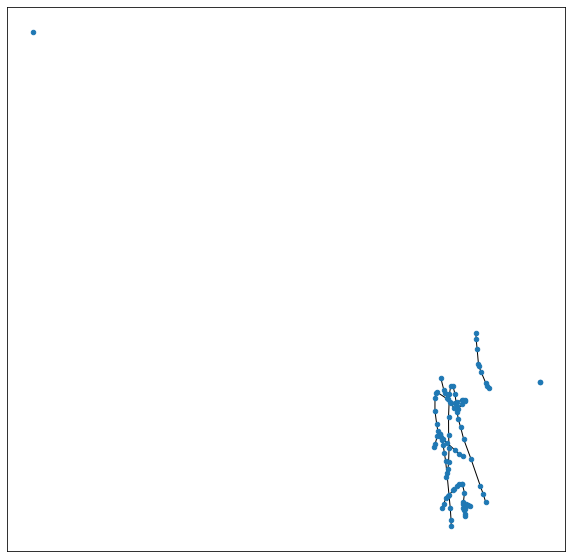

In [721]:
fig, ax = plt.subplots(figsize=(10,10))
nx.draw_networkx(quot, with_labels=False, nodelist=None, edge_cmap='viridis', font_weight='bold', node_size=20)
plt.show()

In [478]:
shorts = [nx.algorithms.shortest_path(ng, 0, 198, weight='weight'),nx.algorithms.shortest_path(ng, , 199, weight='weight')]

SyntaxError: invalid syntax (<ipython-input-478-41b45ca066f2>, line 1)

In [30]:
set(shorts[0]) & set(shorts[1])

set()

In [31]:
ccs = np.array(list(nx.algorithms.connected_components(ng)))

In [19]:
def label_from_cc(ccs, regions):
    
    labels = np.zeros_like(regions, dtype=int)
    
    for i, c in enumerate(ccs):
        
        for n in c:
            
            labels[n] = i+1
    
    return labels

In [480]:
test_chr['Label graph'] = label_from_cc(ccs, test_chr['Region ID'])

Connected components may be too simple of a metric - there can still be two duplicate loci within the same connected component as long as there is an allowed path between them. This graph can be a good starting point though, perhaps at least to get rough separation. Also for cases where the two homologues are quite close, the whole thing might be connected if genomically nearby loci happen to be near in space too. You need to at least identify one or more cuts, or use coloring based on genomic region (perhaps actually *connecting* the identical allele copies? or other way with a bipartite graph?)

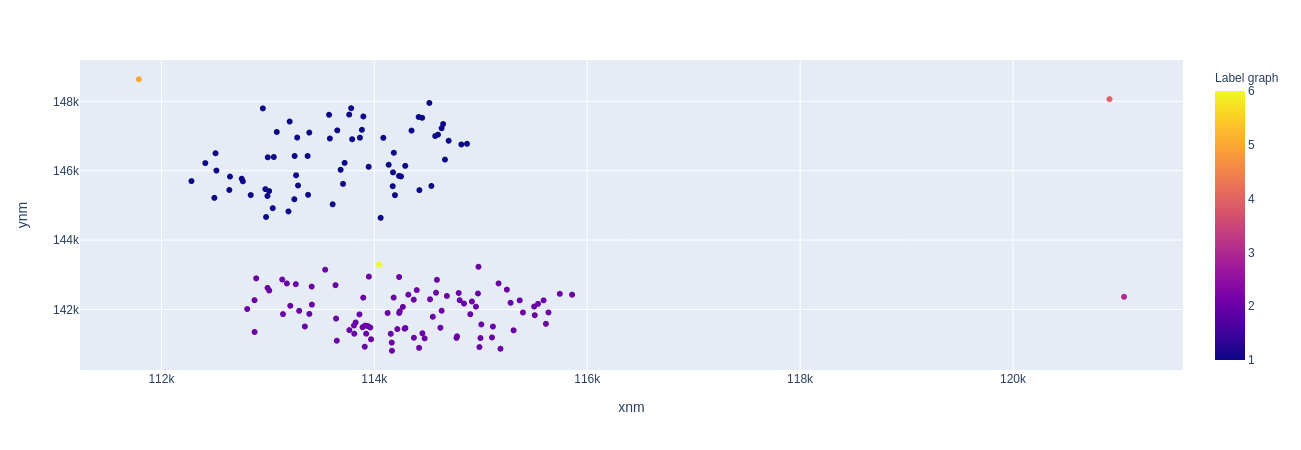

In [482]:
fig = px.scatter(test_chr, 
                x='xnm', y='ynm', 
                #animation_frame='Chrom ID',
                #animation_group='Label',
                color='Label graph',
                #range_x=[50e3, 80e3], range_y=[85e3, 115e3]
                )

fig["layout"].pop("updatemenus") # optional, drop animation buttons
fig.show()

# Ad hoc approach

* Identify "seed" loci: genomically earliest that have at least one distinct "valid" connection
* Defining "valid" connection: spatial and genomic distance both less than some threshold 
    * Cost of a connection is product (or other func) of spatial and genomic distance (can square it to more strongly prefer nearest neighbor connections)
* Make connections from first seed until you are at the end of the chromosome, or only "strongly" invalid moves remain 
    * Some provision for accepting less-than-optimal moves in the interest of getting a full cluster - perhaps cost is damped at the start and ramps up, so that more bold moves are made at the start
* Once first seed finishes, remove these nodes from future searches.
* Repeat with second seed etc until bad moves only remain
* Possibly shuffle seeds and try again to see agreement/dependence on initial seed?

## Main loop

In [20]:
adhoc_results = adhoc_alleles(
    test_chr,
    n_seeds=3,
    sp_thresh_max=5000,
    gen_thresh_max=100,
)

In [21]:
adhoc_results

([[0,
   3,
   9,
   13,
   14,
   16,
   59,
   62,
   66,
   67,
   68,
   70,
   72,
   78,
   87,
   89,
   91,
   93,
   96,
   101,
   110,
   113,
   114,
   122,
   124,
   127,
   133,
   134,
   138,
   140,
   147,
   149,
   152,
   153,
   155,
   156,
   157,
   168,
   170,
   208,
   209,
   211,
   214,
   232,
   235,
   266],
  [2,
   4,
   5,
   6,
   7,
   40,
   41,
   43,
   46,
   51,
   53,
   54,
   57,
   58,
   60,
   61,
   64,
   65,
   69,
   71,
   75,
   76,
   77,
   79,
   81,
   83,
   84,
   88,
   92,
   94,
   97,
   103,
   108,
   109,
   115,
   119,
   121,
   123,
   125,
   129,
   136,
   139,
   141,
   142,
   146,
   148,
   150,
   151,
   154,
   160,
   161,
   164,
   173,
   177,
   180,
   183,
   187,
   189,
   192,
   195,
   199,
   200,
   203,
   207,
   210,
   212,
   213,
   216,
   218,
   221,
   222,
   226,
   228,
   233,
   234,
   237,
   240,
   241,
   244,
   245,
   248,
   249,
   250,
   252,
   255,
   256,
 

In [23]:
test_chr['Label adhoc'] = label_from_cc(adhoc_results[0], test_chr['Region ID'])

In [26]:
p = bokeh.plotting.figure()

p.line(test_chr.query('`Label adhoc`==2')['xnm'], 
       test_chr.query('`Label adhoc`==2')['ynm'], 
         color='green'
        )

p.line(test_chr.query('`Label adhoc`==1')['xnm'], 
       test_chr.query('`Label adhoc`==1')['ynm'], 
         color='red'
        )
bokeh.io.show(p)

In [29]:
summarize_clusters(test_chr, label_col='Label adhoc')

Label  Total loci  Percent nonunique loci    Path length  Path std dev  \
0      0          87                0.275862  555687.729075   4666.374353   
1      1          46                0.000000  101952.976626   3594.177219   
2      2          90                0.000000  210605.708655   3882.286423   
3      3          16                0.000000   12608.042638    566.019790   

   Maximum jump  Silhouette  Calinski-harabasz  Davies-bouldin  
0  13312.529448   -0.237336          56.075389        3.633678  
1  11858.726498   -0.237336          56.075389        3.633678  
2  12687.377475   -0.237336          56.075389        3.633678  
3   2360.572865   -0.237336          56.075389        3.633678

In [30]:
p = bokeh.plotting.figure()

p.circle(test_chr['xnm'], test_chr['ynm'], color=[ ['black', 'red', 'green', 'blue'][i] for i in test_chr['Label adhoc'].values ])

bokeh.io.show(p)

In [618]:
costs

[[0,
  727.2092475897365,
  4327.438695677604,
  415.58867222889955,
  1089.7476950533005,
  392.5767662062848,
  12409.382790256755,
  194.37038772661407,
  328.78691028233624,
  530.7715763424098,
  1976.6650801397973,
  5315.836669389275,
  1181.5307384133987,
  595.8655208451005,
  2965.818785839773,
  115.12282847462811,
  111.1875523428895,
  437.8441447147645,
  419.38743977973115,
  1737.9918301672324,
  4169.713289667791,
  569.0044020471131,
  596.5690897289112,
  1349.4304692009816,
  757.9308489070213,
  1371.1278739271272,
  5390.665139871344,
  723.472986743845,
  864.6366745518121,
  1505.9289431947625,
  617.071554708221,
  503.5889899610594,
  653.2743683705665,
  4520.169668997411,
  542.3282436457906,
  895.8457316882606,
  1642.5299729380445,
  262.3606920729463,
  618.5774100401437,
  495.34706180310377,
  808.8238956812337,
  5063.649623398556,
  600.9418890807633,
  1316.2402819014499,
  9748.93184894618,
  628.0579019755245,
  1682.6091195807708,
  941.430487463